In [1]:
import sys
import time
import math
sys.path.insert(0, r'/home/danis/work/python_works/gamma_4/Scripts')
sys.path.insert(0, r'D:\Учеба\Практика\Диплом\gamma_4\Scripts')
import numpy as np
import pandas as pd
from materials import*
import matplotlib.pyplot as plt

Минимальная энергия: 1e-3
windows (w) or linux (l): l


Параметры пучков и спектры

In [10]:
linspace1 = np.linspace(0.035, 0.1, 25, dtype=np.float32)
linspace2 = np.geomspace(0.11, 3, 25, dtype=np.float32)

beams_energyes = []
beams_energyes.extend(linspace1)
beams_energyes.extend(linspace2)

In [11]:
m = 30
target = R(Material(m), 0.01)

brems = [target.brem(beams_energy) for beams_energy in beams_energyes]
brems_e = [brem * en for brem in brems]

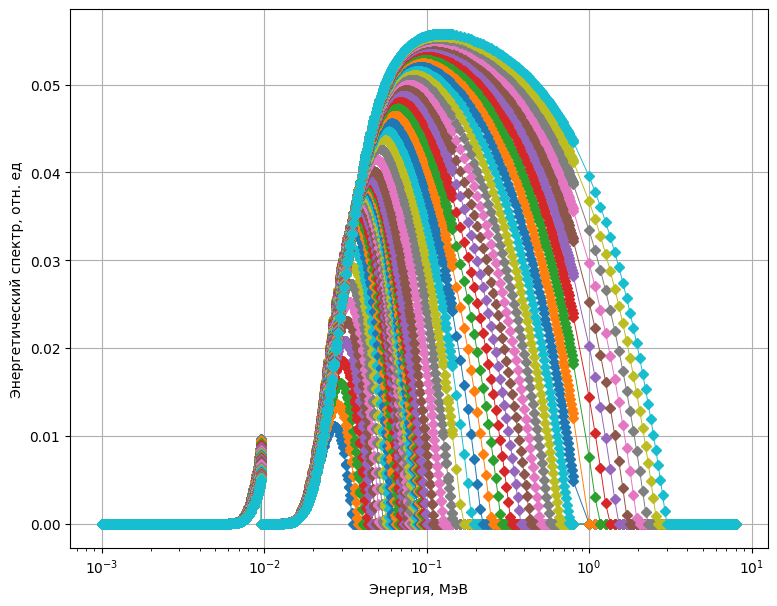

In [12]:
fig, ax = plt.subplots(figsize=(9, 7))

for br in brems_e:
    ax.plot(en, br, ls='-', marker='D', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

Номер первого канала и К-скачки

In [13]:
n = 11

In [14]:
# Индексы К скачков
EDGE = []
for i in range(1, len(en)):
    if en[i - 1] == en[i]:
        EDGE.append(i - 1)

In [15]:
EDGE.remove(EDGE[EDGE.index(Material(m).k_index())])

Уровни пропускания в К-крае

In [16]:
linspace3 = np.linspace(0.001, 0.9, 51)
for i, val in enumerate(linspace3):
    linspace3[i] = round(val, 5)
    
edge_max_values = []
edge_max_values.extend(linspace3)

Спектральные характеристики чувствительности каналов

In [17]:
edge_thiknesses = [[Material(i).lt(j) for i in range(n, 101)] for j in edge_max_values]

In [18]:
edge_regions = [[R(Material(i+n), edge_thiknesses[j][i]) for i in range(0, len(edge_thiknesses[j]))] for j in range(len(edge_thiknesses))]
resp_edges = [[val.f() for val in edge_regions[j]] for j in range(len(edge_regions))]

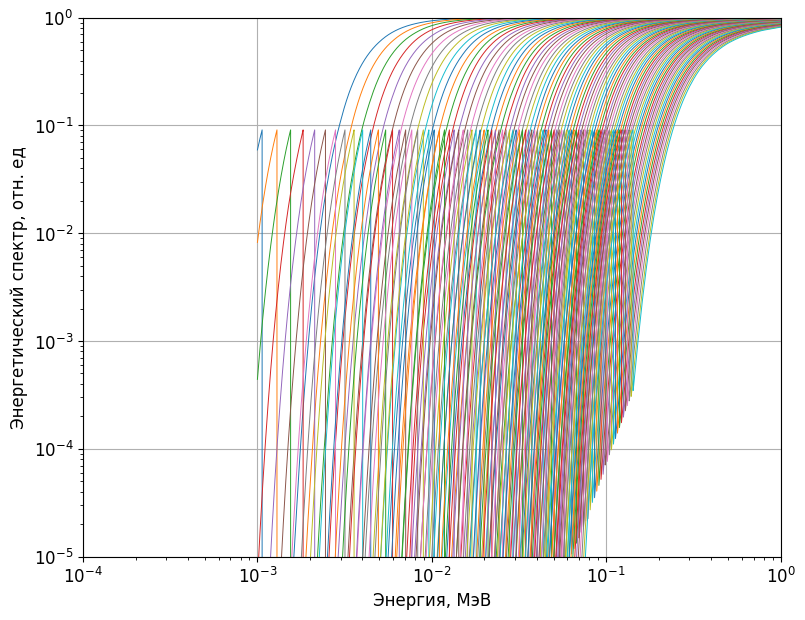

In [19]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in resp_edges[5]:
    ax.plot(en, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-4, 1e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

Матрицы задач

In [20]:
from garipov_deconvolution import get_coeff_simpson

In [21]:
Matrixs = []

start_time = time.time()

for i in range(len(resp_edges)):
    print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
    matrix = []
    
    for response in resp_edges[i]:
        matrix.append(get_coeff_simpson(response, en, EDGE)[0])
    
    Matrixs.append(matrix)

(0), время: 0.00051 секунд
(1), время: 2.88608 секунд
(2), время: 5.73555 секунд
(3), время: 8.49393 секунд
(4), время: 11.24726 секунд
(5), время: 14.03225 секунд
(6), время: 16.74238 секунд
(7), время: 19.47637 секунд
(8), время: 22.48675 секунд
(9), время: 25.52956 секунд
(10), время: 28.56198 секунд
(11), время: 31.84 секунд
(12), время: 35.33573 секунд
(13), время: 38.20929 секунд
(14), время: 41.18 секунд
(15), время: 44.17542 секунд
(16), время: 47.00702 секунд
(17), время: 50.01976 секунд
(18), время: 53.17545 секунд
(19), время: 56.21517 секунд
(20), время: 59.34583 секунд
(21), время: 62.43618 секунд
(22), время: 65.57326 секунд
(23), время: 69.15961 секунд
(24), время: 72.06132 секунд
(25), время: 75.05304 секунд
(26), время: 77.85769 секунд
(27), время: 80.66613 секунд
(28), время: 83.45733 секунд
(29), время: 86.27342 секунд
(30), время: 88.9598 секунд
(31), время: 91.62688 секунд
(32), время: 94.31048 секунд
(33), время: 96.98722 секунд
(34), время: 99.72456 секунд
(35), 

Сигналы измерительных каналов

In [22]:
new_en = get_coeff_simpson(resp_edges[0][0], en, EDGE)[1]

In [23]:
def signals_from_one_spectrum(spectrum):
    
    start_time = time.time()
    signals_simpson = []
    
    # для каждой матрицы
    for i, matrix in enumerate(Matrixs):
        print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
        
        # сигналы для каждой задачи
        signals = []
        
        # для каждой строки в матрице
        for row in matrix:
            # значение одного сигнала
            signal = sum(row * np.interp(new_en, en, spectrum))
            signals.append(signal)
            
        signals_simpson.append(signals)
        
    return signals_simpson

Сигналы для каждого спектра

In [24]:
spectrums_signals = []

for spectrum in brems_e:
    spectrums_signals.append(signals_from_one_spectrum(spectrum))

(0), время: 0.0 секунд
(1), время: 0.03244 секунд
(2), время: 0.06348 секунд
(3), время: 0.09371 секунд
(4), время: 0.12421 секунд
(5), время: 0.15418 секунд
(6), время: 0.1842 секунд
(7), время: 0.21722 секунд
(8), время: 0.25103 секунд
(9), время: 0.28472 секунд
(10), время: 0.31734 секунд
(11), время: 0.3476 секунд
(12), время: 0.38124 секунд
(13), время: 0.41653 секунд
(14), время: 0.45376 секунд
(15), время: 0.48798 секунд
(16), время: 0.52253 секунд
(17), время: 0.5579 секунд
(18), время: 0.58934 секунд
(19), время: 0.61944 секунд
(20), время: 0.65022 секунд
(21), время: 0.69335 секунд
(22), время: 0.73198 секунд
(23), время: 0.77242 секунд
(24), время: 0.81067 секунд
(25), время: 0.85048 секунд
(26), время: 0.88717 секунд
(27), время: 0.92895 секунд
(28), время: 0.96437 секунд
(29), время: 1.00976 секунд
(30), время: 1.04085 секунд
(31), время: 1.07291 секунд
(32), время: 1.10396 секунд
(33), время: 1.13715 секунд
(34), время: 1.16749 секунд
(35), время: 1.19602 секунд
(36), вре

(43), время: 1.35194 секунд
(44), время: 1.38305 секунд
(45), время: 1.41339 секунд
(46), время: 1.44655 секунд
(47), время: 1.47729 секунд
(48), время: 1.51002 секунд
(49), время: 1.5419 секунд
(50), время: 1.5769 секунд
(0), время: 0.0 секунд
(1), время: 0.03161 секунд
(2), время: 0.06352 секунд
(3), время: 0.09957 секунд
(4), время: 0.13591 секунд
(5), время: 0.17129 секунд
(6), время: 0.20211 секунд
(7), время: 0.23216 секунд
(8), время: 0.26082 секунд
(9), время: 0.28916 секунд
(10), время: 0.31887 секунд
(11), время: 0.35141 секунд
(12), время: 0.38825 секунд
(13), время: 0.42448 секунд
(14), время: 0.4618 секунд
(15), время: 0.49418 секунд
(16), время: 0.52817 секунд
(17), время: 0.55901 секунд
(18), время: 0.5896 секунд
(19), время: 0.62183 секунд
(20), время: 0.6568 секунд
(21), время: 0.69574 секунд
(22), время: 0.73258 секунд
(23), время: 0.76817 секунд
(24), время: 0.80149 секунд
(25), время: 0.83151 секунд
(26), время: 0.86136 секунд
(27), время: 0.89144 секунд
(28), время

(34), время: 1.06685 секунд
(35), время: 1.09515 секунд
(36), время: 1.12313 секунд
(37), время: 1.15142 секунд
(38), время: 1.18997 секунд
(39), время: 1.22396 секунд
(40), время: 1.25406 секунд
(41), время: 1.28406 секунд
(42), время: 1.31183 секунд
(43), время: 1.33901 секунд
(44), время: 1.36629 секунд
(45), время: 1.41701 секунд
(46), время: 1.4738 секунд
(47), время: 1.51922 секунд
(48), время: 1.55123 секунд
(49), время: 1.57963 секунд
(50), время: 1.6101 секунд
(0), время: 1e-05 секунд
(1), время: 0.03457 секунд
(2), время: 0.06272 секунд
(3), время: 0.09243 секунд
(4), время: 0.12062 секунд
(5), время: 0.14869 секунд
(6), время: 0.17709 секунд
(7), время: 0.20694 секунд
(8), время: 0.23968 секунд
(9), время: 0.26904 секунд
(10), время: 0.2991 секунд
(11), время: 0.32742 секунд
(12), время: 0.35535 секунд
(13), время: 0.38357 секунд
(14), время: 0.41189 секунд
(15), время: 0.44002 секунд
(16), время: 0.4681 секунд
(17), время: 0.49676 секунд
(18), время: 0.5269 секунд
(19), вре

(27), время: 0.84219 секунд
(28), время: 0.87605 секунд
(29), время: 0.90959 секунд
(30), время: 0.9393 секунд
(31), время: 0.96876 секунд
(32), время: 0.99723 секунд
(33), время: 1.02556 секунд
(34), время: 1.05925 секунд
(35), время: 1.08965 секунд
(36), время: 1.11806 секунд
(37), время: 1.14738 секунд
(38), время: 1.17558 секунд
(39), время: 1.20386 секунд
(40), время: 1.23235 секунд
(41), время: 1.26989 секунд
(42), время: 1.2992 секунд
(43), время: 1.3273 секунд
(44), время: 1.35754 секунд
(45), время: 1.38609 секунд
(46), время: 1.41459 секунд
(47), время: 1.44598 секунд
(48), время: 1.47797 секунд
(49), время: 1.50617 секунд
(50), время: 1.53421 секунд
(0), время: 0.0 секунд
(1), время: 0.02838 секунд
(2), время: 0.05644 секунд
(3), время: 0.08459 секунд
(4), время: 0.11254 секунд
(5), время: 0.15006 секунд
(6), время: 0.17909 секунд
(7), время: 0.20751 секунд
(8), время: 0.23595 секунд
(9), время: 0.26581 секунд
(10), время: 0.294 секунд
(11), время: 0.32231 секунд
(12), время

(19), время: 0.5583 секунд
(20), время: 0.58632 секунд
(21), время: 0.6141 секунд
(22), время: 0.64229 секунд
(23), время: 0.69242 секунд
(24), время: 0.72176 секунд
(25), время: 0.75042 секунд
(26), время: 0.78064 секунд
(27), время: 0.80916 секунд
(28), время: 0.83692 секунд
(29), время: 0.86511 секунд
(30), время: 0.89319 секунд
(31), время: 0.92123 секунд
(32), время: 0.95768 секунд
(33), время: 0.99314 секунд
(34), время: 1.02673 секунд
(35), время: 1.05516 секунд
(36), время: 1.08388 секунд
(37), время: 1.11254 секунд
(38), время: 1.14101 секунд
(39), время: 1.16949 секунд
(40), время: 1.19946 секунд
(41), время: 1.22803 секунд
(42), время: 1.25653 секунд
(43), время: 1.28473 секунд
(44), время: 1.32556 секунд
(45), время: 1.36565 секунд
(46), время: 1.39464 секунд
(47), время: 1.42481 секунд
(48), время: 1.45332 секунд
(49), время: 1.48129 секунд
(50), время: 1.50949 секунд
(0), время: 0.0 секунд
(1), время: 0.02815 секунд
(2), время: 0.05606 секунд
(3), время: 0.08393 секунд
(4

(12), время: 0.38562 секунд
(13), время: 0.41809 секунд
(14), время: 0.45264 секунд
(15), время: 0.48818 секунд
(16), время: 0.54612 секунд
(17), время: 0.60415 секунд
(18), время: 0.66117 секунд
(19), время: 0.71791 секунд
(20), время: 0.77355 секунд
(21), время: 0.82994 секунд
(22), время: 0.87597 секунд
(23), время: 0.904 секунд
(24), время: 0.93227 секунд
(25), время: 0.96048 секунд
(26), время: 0.98875 секунд
(27), время: 1.01711 секунд
(28), время: 1.04752 секунд
(29), время: 1.07584 секунд
(30), время: 1.1041 секунд
(31), время: 1.13242 секунд
(32), время: 1.16076 секунд
(33), время: 1.18908 секунд
(34), время: 1.21739 секунд
(35), время: 1.24573 секунд
(36), время: 1.27578 секунд
(37), время: 1.30387 секунд
(38), время: 1.33171 секунд
(39), время: 1.36019 секунд
(40), время: 1.38932 секунд
(41), время: 1.41872 секунд
(42), время: 1.44826 секунд
(43), время: 1.47951 секунд
(44), время: 1.54129 секунд
(45), время: 1.60932 секунд
(46), время: 1.6483 секунд
(47), время: 1.68624 сек

(8), время: 0.23026 секунд
(9), время: 0.25851 секунд
(10), время: 0.28633 секунд
(11), время: 0.31455 секунд
(12), время: 0.34281 секунд
(13), время: 0.37153 секунд
(14), время: 0.39973 секунд
(15), время: 0.43226 секунд
(16), время: 0.46185 секунд
(17), время: 0.49027 секунд
(18), время: 0.51995 секунд
(19), время: 0.5515 секунд
(20), время: 0.58316 секунд
(21), время: 0.6157 секунд
(22), время: 0.6512 секунд
(23), время: 0.68677 секунд
(24), время: 0.72109 секунд
(25), время: 0.75702 секунд
(26), время: 0.79401 секунд
(27), время: 0.82954 секунд
(28), время: 0.87068 секунд
(29), время: 0.9055 секунд
(30), время: 0.93842 секунд
(31), время: 0.96969 секунд
(32), время: 1.00126 секунд
(33), время: 1.03297 секунд
(34), время: 1.06434 секунд
(35), время: 1.09741 секунд
(36), время: 1.12613 секунд
(37), время: 1.15416 секунд
(38), время: 1.18254 секунд
(39), время: 1.21083 секунд
(40), время: 1.2396 секунд
(41), время: 1.26816 секунд
(42), время: 1.2967 секунд
(43), время: 1.32715 секунд


(5), время: 0.14302 секунд
(6), время: 0.1717 секунд
(7), время: 0.19995 секунд
(8), время: 0.23097 секунд
(9), время: 0.25933 секунд
(10), время: 0.28777 секунд
(11), время: 0.31617 секунд
(12), время: 0.3457 секунд
(13), время: 0.37513 секунд
(14), время: 0.4036 секунд
(15), время: 0.43211 секунд
(16), время: 0.46041 секунд
(17), время: 0.48879 секунд
(18), время: 0.51709 секунд
(19), время: 0.54537 секунд
(20), время: 0.57545 секунд
(21), время: 0.60365 секунд
(22), время: 0.63152 секунд
(23), время: 0.65976 секунд
(24), время: 0.68795 секунд
(25), время: 0.71612 секунд
(26), время: 0.74509 секунд
(27), время: 0.77454 секунд
(28), время: 0.80504 секунд
(29), время: 0.8335 секунд
(30), время: 0.86208 секунд
(31), время: 0.89069 секунд
(32), время: 0.91908 секунд
(33), время: 0.94747 секунд
(34), время: 0.97576 секунд
(35), время: 1.00387 секунд
(36), время: 1.0338 секунд
(37), время: 1.0621 секунд
(38), время: 1.08999 секунд
(39), время: 1.11817 секунд
(40), время: 1.14731 секунд
(41

(50), время: 1.89975 секунд
(0), время: 0.0 секунд
(1), время: 0.05721 секунд
(2), время: 0.11437 секунд
(3), время: 0.17182 секунд
(4), время: 0.22793 секунд
(5), время: 0.28365 секунд
(6), время: 0.33999 секунд
(7), время: 0.38919 секунд
(8), время: 0.44546 секунд
(9), время: 0.50169 секунд
(10), время: 0.55843 секунд
(11), время: 0.61783 секунд
(12), время: 0.65476 секунд
(13), время: 0.69166 секунд
(14), время: 0.7337 секунд
(15), время: 0.77283 секунд
(16), время: 0.81198 секунд
(17), время: 0.85186 секунд
(18), время: 0.88906 секунд
(19), время: 0.92141 секунд
(20), время: 0.95298 секунд
(21), время: 0.98405 секунд
(22), время: 1.01502 секунд
(23), время: 1.04608 секунд
(24), время: 1.08169 секунд
(25), время: 1.11467 секунд
(26), время: 1.14987 секунд
(27), время: 1.1946 секунд
(28), время: 1.22942 секунд
(29), время: 1.26115 секунд
(30), время: 1.29539 секунд
(31), время: 1.32764 секунд
(32), время: 1.35597 секунд
(33), время: 1.38465 секунд
(34), время: 1.41324 секунд
(35), вр

Восстановление спектров

In [25]:
from garipov_deconvolution import Gold

In [26]:
def deconvolution_one_spectrum(spectrum, signals_from_this_spectrum):
    
    sp = [0 for i in range(len(resp_edges))]
    dev = [0 for i in range(len(resp_edges))]
    norm = [0 for i in range(len(resp_edges))]
    
    start_time = time.time()
    
    for i in range(len(resp_edges)):
        print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
        sp[i], norm[i], dev[i] = Gold(Matrixs[i], signals_from_this_spectrum[i], en, spectrum, new_en, 1, 10000, w=True, d=False)[:3]
    return sp, dev

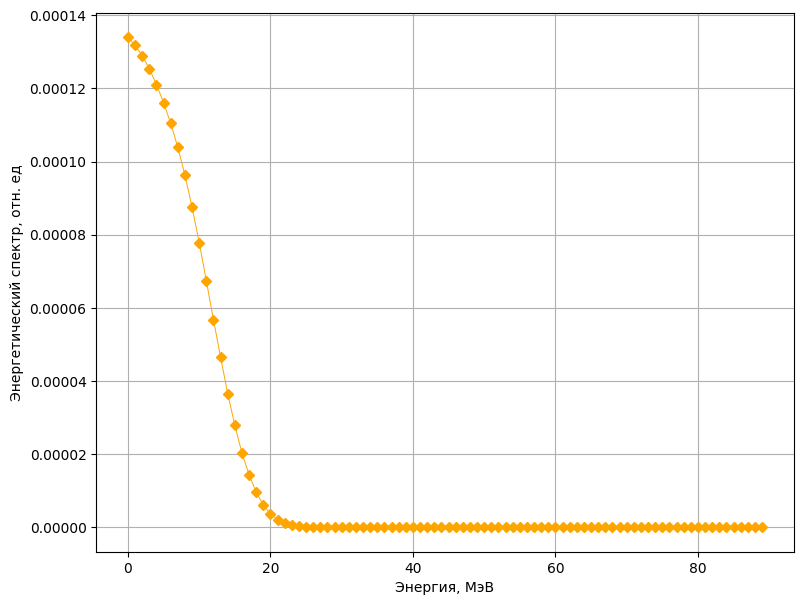

In [27]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(range(90), spectrums_signals[0][0], ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1.e-5, 0.3e-4)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

Скрипт

In [28]:
SP, DEV = [], []

for j in range(len(brems_e)):
    sp, dev = deconvolution_one_spectrum(brems_e[j], spectrums_signals[j])
    SP.append(sp)
    DEV.append(dev)
    print(f'ВЫПОЛНЕНО {j+1} из {len(brems_e)}')

(0), время: 0.0 секунд
(1), время: 6.39207 секунд
(2), время: 11.81087 секунд
(3), время: 17.69034 секунд
(4), время: 23.29042 секунд
(5), время: 29.2641 секунд
(6), время: 41.74554 секунд
(7), время: 46.45699 секунд
(8), время: 51.17706 секунд
(9), время: 56.03533 секунд
(10), время: 61.34854 секунд
(11), время: 66.2324 секунд
(12), время: 70.91935 секунд
(13), время: 80.95419 секунд
(14), время: 88.73171 секунд
(15), время: 97.44107 секунд
(16), время: 103.99019 секунд
(17), время: 110.26694 секунд
(18), время: 115.7175 секунд
(19), время: 122.10996 секунд
(20), время: 128.62362 секунд
(21), время: 134.82084 секунд
(22), время: 141.46418 секунд
(23), время: 146.06285 секунд
(24), время: 153.20229 секунд
(25), время: 160.13613 секунд
(26), время: 170.14306 секунд
(27), время: 178.41929 секунд
(28), время: 183.95992 секунд
(29), время: 191.14696 секунд
(30), время: 197.35905 секунд
(31), время: 204.24178 секунд
(32), время: 212.37437 секунд
(33), время: 217.91974 секунд
(34), время: 22

(24), время: 126.81393 секунд
(25), время: 131.93128 секунд
(26), время: 137.60383 секунд
(27), время: 143.67901 секунд
(28), время: 149.67699 секунд
(29), время: 155.59815 секунд
(30), время: 161.23937 секунд
(31), время: 166.6532 секунд
(32), время: 172.54527 секунд
(33), время: 178.1875 секунд
(34), время: 184.95673 секунд
(35), время: 191.33714 секунд
(36), время: 197.20257 секунд
(37), время: 203.33424 секунд
(38), время: 208.73905 секунд
(39), время: 213.87665 секунд
(40), время: 220.00097 секунд
(41), время: 225.63563 секунд
(42), время: 231.63155 секунд
(43), время: 236.82034 секунд
(44), время: 242.42573 секунд
(45), время: 248.26743 секунд
(46), время: 253.16364 секунд
(47), время: 258.54565 секунд
(48), время: 264.02045 секунд
(49), время: 269.04035 секунд
(50), время: 275.52276 секунд
ВЫПОЛНЕНО 6 из 50
(0), время: 0.0 секунд
(1), время: 8.5895 секунд
(2), время: 18.13626 секунд
(3), время: 25.4395 секунд
(4), время: 41.26327 секунд
(5), время: 53.1848 секунд
(6), время: 62.

(46), время: 257.40366 секунд
(47), время: 265.01397 секунд
(48), время: 269.92383 секунд
(49), время: 274.79439 секунд
(50), время: 279.00414 секунд
ВЫПОЛНЕНО 11 из 50
(0), время: 0.0 секунд
(1), время: 5.33185 секунд
(2), время: 9.90817 секунд
(3), время: 14.54066 секунд
(4), время: 19.49251 секунд
(5), время: 23.83447 секунд
(6), время: 27.8707 секунд
(7), время: 32.82516 секунд
(8), время: 37.20325 секунд
(9), время: 41.62523 секунд
(10), время: 46.4292 секунд
(11), время: 50.79493 секунд
(12), время: 56.80526 секунд
(13), время: 62.07865 секунд
(14), время: 69.98785 секунд
(15), время: 77.74371 секунд
(16), время: 83.76857 секунд
(17), время: 89.02656 секунд
(18), время: 93.4911 секунд
(19), время: 98.25688 секунд
(20), время: 103.96154 секунд
(21), время: 108.49547 секунд
(22), время: 113.27192 секунд
(23), время: 117.79076 секунд
(24), время: 122.37392 секунд
(25), время: 127.27361 секунд
(26), время: 132.14213 секунд
(27), время: 137.11103 секунд
(28), время: 142.00061 секунд
(

(18), время: 85.72094 секунд
(19), время: 90.63201 секунд
(20), время: 95.41443 секунд
(21), время: 100.36675 секунд
(22), время: 105.20112 секунд
(23), время: 110.6564 секунд
(24), время: 115.43026 секунд
(25), время: 120.41507 секунд
(26), время: 125.61197 секунд
(27), время: 130.74203 секунд
(28), время: 135.90235 секунд
(29), время: 140.9865 секунд
(30), время: 146.03867 секунд
(31), время: 150.79592 секунд
(32), время: 155.56103 секунд
(33), время: 160.83354 секунд
(34), время: 165.74559 секунд
(35), время: 170.75576 секунд
(36), время: 175.94085 секунд
(37), время: 180.6457 секунд
(38), время: 186.06444 секунд
(39), время: 190.64582 секунд
(40), время: 195.6893 секунд
(41), время: 200.54007 секунд
(42), время: 205.08285 секунд
(43), время: 209.30244 секунд
(44), время: 213.99711 секунд
(45), время: 218.8341 секунд
(46), время: 223.37413 секунд
(47), время: 228.05642 секунд
(48), время: 232.45871 секунд
(49), время: 237.17518 секунд
(50), время: 242.09811 секунд
ВЫПОЛНЕНО 17 из 50

(41), время: 202.00452 секунд
(42), время: 206.80969 секунд
(43), время: 211.53653 секунд
(44), время: 216.42327 секунд
(45), время: 221.43193 секунд
(46), время: 226.16726 секунд
(47), время: 230.60841 секунд
(48), время: 235.0516 секунд
(49), время: 239.5339 секунд
(50), время: 244.25557 секунд
ВЫПОЛНЕНО 22 из 50
(0), время: 0.0 секунд
(1), время: 4.86215 секунд
(2), время: 9.74664 секунд
(3), время: 14.84042 секунд
(4), время: 19.89332 секунд
(5), время: 24.86172 секунд
(6), время: 29.32823 секунд
(7), время: 34.6299 секунд
(8), время: 39.40321 секунд
(9), время: 44.60388 секунд
(10), время: 49.40087 секунд
(11), время: 54.04439 секунд
(12), время: 59.48958 секунд
(13), время: 64.23933 секунд
(14), время: 69.66179 секунд
(15), время: 74.66982 секунд
(16), время: 79.43844 секунд
(17), время: 84.58381 секунд
(18), время: 89.19984 секунд
(19), время: 93.7048 секунд
(20), время: 98.73739 секунд
(21), время: 103.58884 секунд
(22), время: 108.39681 секунд
(23), время: 113.55551 секунд
(24

(13), время: 63.67617 секунд
(14), время: 68.63218 секунд
(15), время: 73.15202 секунд
(16), время: 77.65486 секунд
(17), время: 82.40433 секунд
(18), время: 87.26956 секунд
(19), время: 91.96355 секунд
(20), время: 96.46083 секунд
(21), время: 101.18862 секунд
(22), время: 106.0637 секунд
(23), время: 110.94916 секунд
(24), время: 116.01334 секунд
(25), время: 120.99194 секунд
(26), время: 126.55491 секунд
(27), время: 131.72707 секунд
(28), время: 136.91794 секунд
(29), время: 141.71862 секунд
(30), время: 146.74858 секунд
(31), время: 151.83877 секунд
(32), время: 157.14052 секунд
(33), время: 163.03394 секунд
(34), время: 168.26406 секунд
(35), время: 173.19575 секунд
(36), время: 178.17903 секунд
(37), время: 182.72332 секунд
(38), время: 187.40223 секунд
(39), время: 192.20452 секунд
(40), время: 197.18286 секунд
(41), время: 201.9478 секунд
(42), время: 206.59208 секунд
(43), время: 211.53346 секунд
(44), время: 216.72401 секунд
(45), время: 221.17091 секунд
(46), время: 225.706

(36), время: 183.35379 секунд
(37), время: 188.03021 секунд
(38), время: 193.26693 секунд
(39), время: 198.55532 секунд
(40), время: 203.71532 секунд
(41), время: 208.37597 секунд
(42), время: 213.24245 секунд
(43), время: 218.47559 секунд
(44), время: 223.15622 секунд
(45), время: 228.08554 секунд
(46), время: 232.88451 секунд
(47), время: 237.58341 секунд
(48), время: 242.55099 секунд
(49), время: 247.1854 секунд
(50), время: 252.48755 секунд
ВЫПОЛНЕНО 33 из 50
(0), время: 0.0 секунд
(1), время: 4.58288 секунд
(2), время: 9.98706 секунд
(3), время: 14.45518 секунд
(4), время: 18.78394 секунд
(5), время: 22.77264 секунд
(6), время: 26.99255 секунд
(7), время: 32.93039 секунд
(8), время: 37.53642 секунд
(9), время: 42.83248 секунд
(10), время: 47.30629 секунд
(11), время: 51.5469 секунд
(12), время: 56.70898 секунд
(13), время: 63.008 секунд
(14), время: 68.07559 секунд
(15), время: 73.67363 секунд
(16), время: 78.05978 секунд
(17), время: 82.21761 секунд
(18), время: 87.29591 секунд
(

(7), время: 33.07232 секунд
(8), время: 37.50891 секунд
(9), время: 41.62568 секунд
(10), время: 46.38232 секунд
(11), время: 50.97294 секунд
(12), время: 55.27423 секунд
(13), время: 60.41333 секунд
(14), время: 64.96953 секунд
(15), время: 69.90611 секунд
(16), время: 74.52861 секунд
(17), время: 79.58636 секунд
(18), время: 84.84478 секунд
(19), время: 90.01972 секунд
(20), время: 95.36134 секунд
(21), время: 100.9428 секунд
(22), время: 105.56493 секунд
(23), время: 110.62071 секунд
(24), время: 115.60707 секунд
(25), время: 121.04871 секунд
(26), время: 126.14817 секунд
(27), время: 130.72355 секунд
(28), время: 135.7388 секунд
(29), время: 140.4055 секунд
(30), время: 146.15462 секунд
(31), время: 151.19819 секунд
(32), время: 155.84745 секунд
(33), время: 160.75653 секунд
(34), время: 165.84295 секунд
(35), время: 171.23496 секунд
(36), время: 176.55673 секунд
(37), время: 182.0994 секунд
(38), время: 186.74696 секунд
(39), время: 191.89883 секунд
(40), время: 198.69947 секунд
(

(30), время: 147.14827 секунд
(31), время: 151.9996 секунд
(32), время: 156.67649 секунд
(33), время: 161.49558 секунд
(34), время: 166.81053 секунд
(35), время: 171.68863 секунд
(36), время: 176.55308 секунд
(37), время: 181.67996 секунд
(38), время: 186.42305 секунд
(39), время: 191.40225 секунд
(40), время: 196.31017 секунд
(41), время: 200.69681 секунд
(42), время: 205.51808 секунд
(43), время: 209.96528 секунд
(44), время: 214.69172 секунд
(45), время: 219.06712 секунд
(46), время: 224.3042 секунд
(47), время: 228.91533 секунд
(48), время: 233.36099 секунд
(49), время: 237.63812 секунд
(50), время: 242.35942 секунд
ВЫПОЛНЕНО 44 из 50
(0), время: 0.0 секунд
(1), время: 4.34583 секунд
(2), время: 9.41785 секунд
(3), время: 14.11946 секунд
(4), время: 18.89551 секунд
(5), время: 23.46696 секунд
(6), время: 28.53299 секунд
(7), время: 32.90092 секунд
(8), время: 37.55793 секунд
(9), время: 42.08246 секунд
(10), время: 47.12162 секунд
(11), время: 52.18831 секунд
(12), время: 57.24703 

(1), время: 6.95245 секунд
(2), время: 11.98935 секунд
(3), время: 17.26708 секунд
(4), время: 22.13544 секунд
(5), время: 26.40512 секунд
(6), время: 30.46501 секунд
(7), время: 34.82698 секунд
(8), время: 39.60925 секунд
(9), время: 45.11174 секунд
(10), время: 49.2173 секунд
(11), время: 53.89022 секунд
(12), время: 58.1137 секунд
(13), время: 62.55103 секунд
(14), время: 68.42535 секунд
(15), время: 73.29047 секунд
(16), время: 79.05122 секунд
(17), время: 85.48533 секунд
(18), время: 91.33495 секунд
(19), время: 96.14985 секунд
(20), время: 101.17819 секунд
(21), время: 107.41917 секунд
(22), время: 114.22016 секунд
(23), время: 119.23939 секунд
(24), время: 123.79924 секунд
(25), время: 129.6034 секунд
(26), время: 134.58937 секунд
(27), время: 139.33481 секунд
(28), время: 145.25583 секунд
(29), время: 150.25636 секунд
(30), время: 154.85457 секунд
(31), время: 160.27922 секунд
(32), время: 165.73351 секунд
(33), время: 171.00006 секунд
(34), время: 176.21261 секунд
(35), время:

Сохранение данных

In [29]:
np.save('Notebook_10_SP_edges.npy', SP)
np.save('Notebook_10_DEV_edges.npy', DEV)

Загрузка данных

Построение

In [30]:
from mpl_toolkits.mplot3d import Axes3D

In [31]:
D = np.array(DEV)
X,Y = np.meshgrid(edge_max_values, beams_energyes)
X, Ylog = np.meshgrid(edge_max_values, np.log10(beams_energyes))
Xlog, Ylog = np.meshgrid(np.log10(edge_max_values), np.log10(beams_energyes))

In [42]:
import matplotlib.ticker as mticker

# My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
    # return f"{10**val:.2e}"      # e-Notation

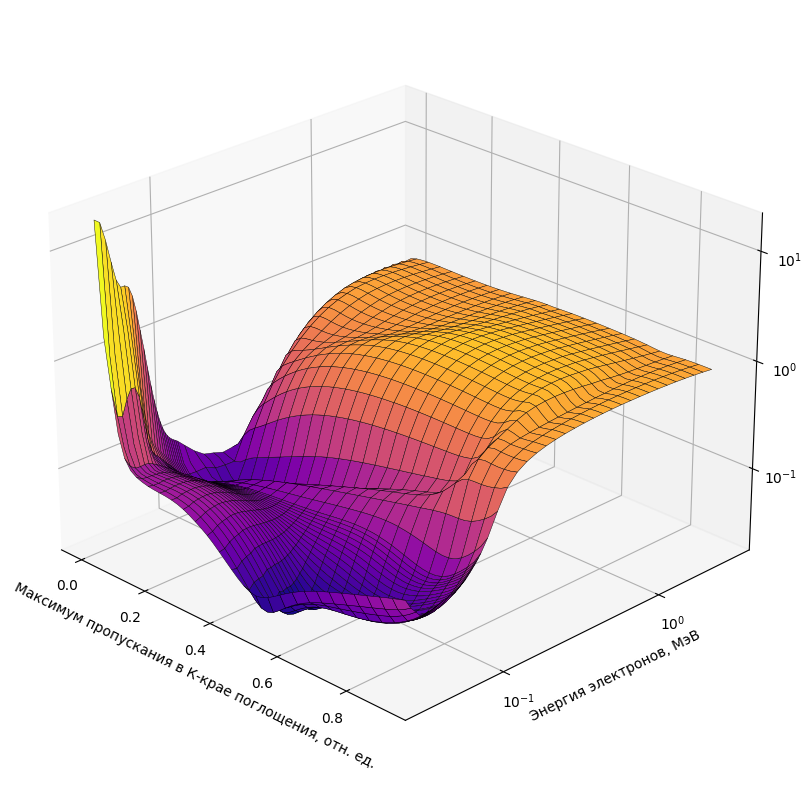

In [47]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': '3d'})
ax.plot_surface(X, Ylog, np.log10(D), cmap='plasma', linewidth=0.3, edgecolors='k', shade=True)

ax.set_xlabel('Максимум пропускания в К-крае поглощения, отн. ед.')
ax.set_ylabel('Энергия электронов, МэВ')
# ax.set_zlabel('Ср.кв. ошибка восстановления, отн. ед.')
fig.tight_layout()

ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# угол зрения (линейный)
# ax.view_init(elev=20, azim=-135)

# угол зрения (логарифм)
ax.view_init(elev=25, azim=-45)

# fig.savefig('К_фильтры_3D_Материал_30.jpg', bbox_inches='tight')

Контурная карта

In [33]:
linspace4 = np.geomspace(1e-2, 0.3, 20)
linspace5 = np.linspace(0.31, 1.4, 10)

In [34]:
c_map_levels = []
c_map_levels.extend(linspace4)
c_map_levels.extend(linspace5)

Text(0, 0.5, 'Энергия электронов, МэВ')

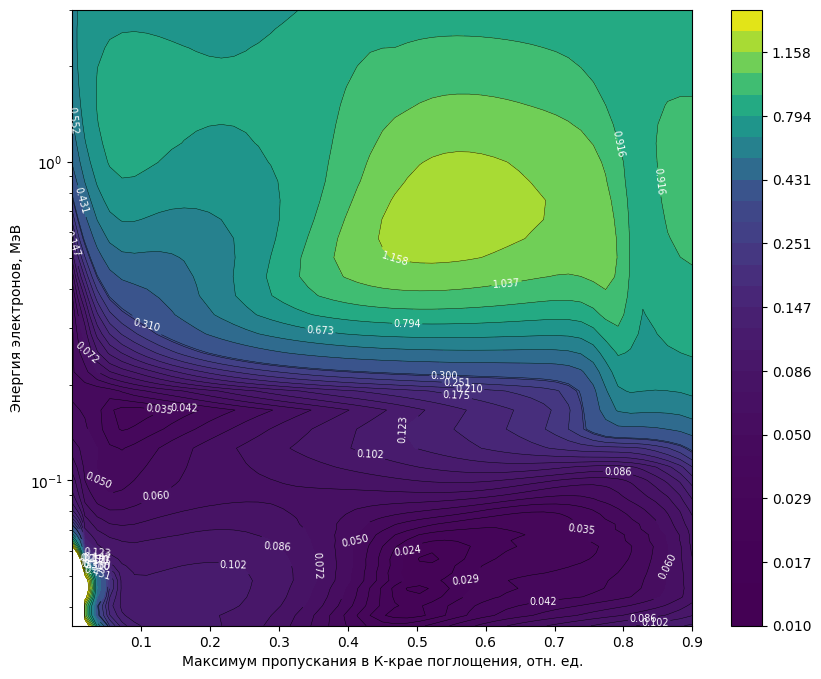

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))

c_map = ax.contourf(X, Y, D, levels=c_map_levels)
borders = ax.contour(X, Y, D, colors='k', levels=c_map_levels, linewidths=0.3)
ax.clabel(borders, fontsize=7, colors='w')
fig.colorbar(c_map)
ax.set_yscale('log')

ax.set_xlabel('Максимум пропускания в К-крае поглощения, отн. ед.')
ax.set_ylabel('Энергия электронов, МэВ')

# fig.savefig('К_фильтры_контурная_карта.jpg', bbox_inches='tight')

Зависимость минимальной ошибки восстановления от граничной энерии спектра

In [36]:
minimal_deviations = []

for i,val in enumerate(beams_energyes):
    min_value = min(DEV[i])
    minimal_deviations.append(min_value)

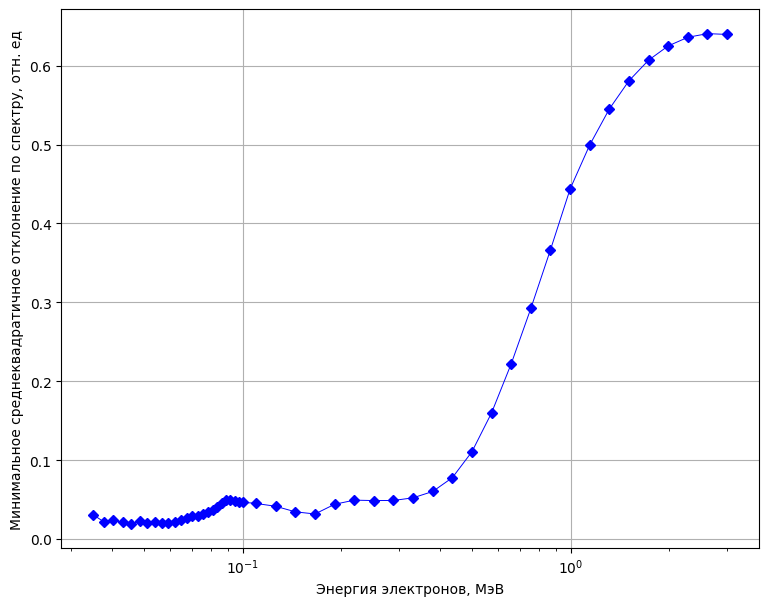

In [37]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(beams_energyes, minimal_deviations, ls='-', marker='D', lw='0.7', ms=5, color='blue')

# настройки графика
ax.set_xlabel('Энергия электронов, МэВ', fontsize=10)
ax.set_ylabel('Минимальное среднеквадратичное отклонение по спектру, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(True)

# fig.savefig('К_фильтры_минимум_ошибки_восстановления_от_энергии_электронов.jpg', bbox_inches='tight')